***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "5" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  5
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_3_2')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 20)          0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 100)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 8)            0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 8)           0           ['prediction_coarse[0][0]']      
 )                                                                                                
          

 tf.math.multiply_8 (TFOpLambda  (None, 100)         0           ['input_yf[0][0]',               
 )                                                                'tf.math.square_4[0][0]']       
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 100)         0           ['tf.math.multiply_9[0][0]',     
 a)                                                               'tf.math.square_5[0][0]']       
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.add[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)      

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.4606 - prediction_coarse_accuracy: 0.4708 - prediction_medium_accuracy: 0.2743 - prediction_fine_accuracy: 0.0931
  • Coarse Accuracy = 47.08% | Val_Accuracy = 57.72% | LossWeight = 0.38 
  • Medium Accuracy = 27.43% | Val_Accuracy = 36.44% | LossWeight = 0.47 
  • Fine   Accuracy = 9.31% | Val_Accuracy = 16.03% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.16030, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 113s 134ms/step - loss: 0.4606 - prediction_coarse_accuracy: 0.4708 - prediction_medium_accuracy: 0.2743 - prediction_fine_accuracy: 0.0931 - val_loss: 0.3899 - val_prediction_coarse_accuracy: 0.5772 - val_prediction_medium_accuracy: 0.3644 - val_prediction_fine_accuracy: 0.1603 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3529 - prediction_coarse_accuracy: 0.6083

781/781 [==============================] - ETA: 0s - loss: 0.1862 - prediction_coarse_accuracy: 0.8474 - prediction_medium_accuracy: 0.7656 - prediction_fine_accuracy: 0.5610
  • Coarse Accuracy = 84.74% | Val_Accuracy = 80.83% | LossWeight = 0.33 
  • Medium Accuracy = 76.56% | Val_Accuracy = 70.09% | LossWeight = 0.45 
  • Fine   Accuracy = 56.10% | Val_Accuracy = 52.57% | LossWeight = 0.22 

Epoch 9: val_prediction_fine_accuracy improved from 0.51760 to 0.52570, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 105s 134ms/step - loss: 0.1862 - prediction_coarse_accuracy: 0.8474 - prediction_medium_accuracy: 0.7656 - prediction_fine_accuracy: 0.5610 - val_loss: 0.1766 - val_prediction_coarse_accuracy: 0.8083 - val_prediction_medium_accuracy: 0.7009 - val_prediction_fine_accuracy: 0.5257 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1757 - prediction_coarse_accuracy: 0.8600 - pred

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1260 - prediction_coarse_accuracy: 0.9221 - prediction_medium_accuracy: 0.8913 - prediction_fine_accuracy: 0.7210
  • Coarse Accuracy = 92.21% | Val_Accuracy = 84.52% | LossWeight = 0.32 
  • Medium Accuracy = 89.13% | Val_Accuracy = 75.95% | LossWeight = 0.41 
  • Fine   Accuracy = 72.10% | Val_Accuracy = 61.35% | LossWeight = 0.27 

Epoch 18: val_prediction_fine_accuracy improved from 0.60660 to 0.61350, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 104s 134ms/step - loss: 0.1260 - prediction_coarse_accuracy: 0.9221 - prediction_medium_accuracy: 0.8913 - prediction_fine_accuracy: 0.7210 - val_loss: 0.1463 - val_prediction_coarse_accuracy: 0.8452 - val_prediction_medium_accuracy: 0.7595 - val_prediction_fine_accuracy: 0.6135 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1238 - prediction_coarse_accur

781/781 [==============================] - ETA: 0s - loss: 0.1070 - prediction_coarse_accuracy: 0.9442 - prediction_medium_accuracy: 0.9260 - prediction_fine_accuracy: 0.7947
  • Coarse Accuracy = 94.42% | Val_Accuracy = 85.37% | LossWeight = 0.33 
  • Medium Accuracy = 92.60% | Val_Accuracy = 76.60% | LossWeight = 0.39 
  • Fine   Accuracy = 79.47% | Val_Accuracy = 62.83% | LossWeight = 0.28 

Epoch 27: val_prediction_fine_accuracy did not improve from 0.63260
781/781 [==============================] - 104s 134ms/step - loss: 0.1070 - prediction_coarse_accuracy: 0.9442 - prediction_medium_accuracy: 0.9260 - prediction_fine_accuracy: 0.7947 - val_loss: 0.1444 - val_prediction_coarse_accuracy: 0.8537 - val_prediction_medium_accuracy: 0.7660 - val_prediction_fine_accuracy: 0.6283 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1033 - prediction_coarse_accuracy: 0.9488 - prediction_medium_accuracy: 0.9327 - prediction_fine_accuracy: 0.8056
  • Co

781/781 [==============================] - ETA: 0s - loss: 0.0983 - prediction_coarse_accuracy: 0.9536 - prediction_medium_accuracy: 0.9412 - prediction_fine_accuracy: 0.8457
  • Coarse Accuracy = 95.36% | Val_Accuracy = 85.84% | LossWeight = 0.34 
  • Medium Accuracy = 94.12% | Val_Accuracy = 78.00% | LossWeight = 0.39 
  • Fine   Accuracy = 84.57% | Val_Accuracy = 64.98% | LossWeight = 0.27 

Epoch 36: val_prediction_fine_accuracy improved from 0.64690 to 0.64980, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 105s 134ms/step - loss: 0.0983 - prediction_coarse_accuracy: 0.9536 - prediction_medium_accuracy: 0.9412 - prediction_fine_accuracy: 0.8457 - val_loss: 0.1403 - val_prediction_coarse_accuracy: 0.8584 - val_prediction_medium_accuracy: 0.7800 - val_prediction_fine_accuracy: 0.6498 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0988 - prediction_coarse_accuracy: 0.9516 -

781/781 [==============================] - ETA: 0s - loss: 0.0964 - prediction_coarse_accuracy: 0.9537 - prediction_medium_accuracy: 0.9419 - prediction_fine_accuracy: 0.8696
  • Coarse Accuracy = 95.37% | Val_Accuracy = 86.11% | LossWeight = 0.36 
  • Medium Accuracy = 94.19% | Val_Accuracy = 77.79% | LossWeight = 0.41 
  • Fine   Accuracy = 86.96% | Val_Accuracy = 65.83% | LossWeight = 0.24 

Epoch 45: val_prediction_fine_accuracy improved from 0.65520 to 0.65830, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 104s 134ms/step - loss: 0.0964 - prediction_coarse_accuracy: 0.9537 - prediction_medium_accuracy: 0.9419 - prediction_fine_accuracy: 0.8696 - val_loss: 0.1401 - val_prediction_coarse_accuracy: 0.8611 - val_prediction_medium_accuracy: 0.7779 - val_prediction_fine_accuracy: 0.6583 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0948 - prediction_coarse_accuracy: 0.9561 -

781/781 [==============================] - 104s 133ms/step - loss: 0.0932 - prediction_coarse_accuracy: 0.9562 - prediction_medium_accuracy: 0.9461 - prediction_fine_accuracy: 0.8890 - val_loss: 0.1389 - val_prediction_coarse_accuracy: 0.8636 - val_prediction_medium_accuracy: 0.7829 - val_prediction_fine_accuracy: 0.6559 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0929 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.8879
  • Coarse Accuracy = 95.84% | Val_Accuracy = 86.44% | LossWeight = 0.36 
  • Medium Accuracy = 94.82% | Val_Accuracy = 78.14% | LossWeight = 0.41 
  • Fine   Accuracy = 88.79% | Val_Accuracy = 65.57% | LossWeight = 0.23 

Epoch 55: val_prediction_fine_accuracy did not improve from 0.65830
781/781 [==============================] - 104s 133ms/step - loss: 0.0929 - prediction_coarse_accuracy: 0.9584 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.887

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0923 - prediction_coarse_accuracy: 0.9569 - prediction_medium_accuracy: 0.9474 - prediction_fine_accuracy: 0.8978
  • Coarse Accuracy = 95.69% | Val_Accuracy = 86.68% | LossWeight = 0.38 
  • Medium Accuracy = 94.74% | Val_Accuracy = 78.59% | LossWeight = 0.41 
  • Fine   Accuracy = 89.78% | Val_Accuracy = 66.10% | LossWeight = 0.21 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.66160
781/781 [==============================] - 104s 133ms/step - loss: 0.0923 - prediction_coarse_accuracy: 0.9569 - prediction_medium_accuracy: 0.9474 - prediction_fine_accuracy: 0.8978 - val_loss: 0.1375 - val_prediction_coarse_accuracy: 0.8668 - val_prediction_medium_accuracy: 0.7859 - val_prediction_fine_accuracy: 0.6610 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0928 - prediction_coarse_accuracy: 0.9573 - prediction_medium_accuracy: 0.9476 - prediction_fine_accuracy: 

781/781 [==============================] - 104s 133ms/step - loss: 0.0901 - prediction_coarse_accuracy: 0.9602 - prediction_medium_accuracy: 0.9500 - prediction_fine_accuracy: 0.9059 - val_loss: 0.1374 - val_prediction_coarse_accuracy: 0.8667 - val_prediction_medium_accuracy: 0.7846 - val_prediction_fine_accuracy: 0.6613 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0911 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9500 - prediction_fine_accuracy: 0.9045
  • Coarse Accuracy = 95.93% | Val_Accuracy = 86.51% | LossWeight = 0.38 
  • Medium Accuracy = 95.00% | Val_Accuracy = 78.49% | LossWeight = 0.42 
  • Fine   Accuracy = 90.45% | Val_Accuracy = 66.10% | LossWeight = 0.21 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.66290
781/781 [==============================] - 104s 133ms/step - loss: 0.0911 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9500 - prediction_fine_accuracy: 0.904

781/781 [==============================] - ETA: 0s - loss: 0.0912 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9499 - prediction_fine_accuracy: 0.9068
  • Coarse Accuracy = 95.92% | Val_Accuracy = 86.68% | LossWeight = 0.38 
  • Medium Accuracy = 94.99% | Val_Accuracy = 78.81% | LossWeight = 0.42 
  • Fine   Accuracy = 90.68% | Val_Accuracy = 66.24% | LossWeight = 0.20 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.66290
781/781 [==============================] - 104s 133ms/step - loss: 0.0912 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9499 - prediction_fine_accuracy: 0.9068 - val_loss: 0.1371 - val_prediction_coarse_accuracy: 0.8668 - val_prediction_medium_accuracy: 0.7881 - val_prediction_fine_accuracy: 0.6624 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0915 - prediction_coarse_accuracy: 0.9595 - prediction_medium_accuracy: 0.9498 - prediction_fine_accuracy: 0.9081
  • Co

781/781 [==============================] - 104s 133ms/step - loss: 0.0907 - prediction_coarse_accuracy: 0.9591 - prediction_medium_accuracy: 0.9497 - prediction_fine_accuracy: 0.9093 - val_loss: 0.1368 - val_prediction_coarse_accuracy: 0.8685 - val_prediction_medium_accuracy: 0.7870 - val_prediction_fine_accuracy: 0.6628 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0903 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9497 - prediction_fine_accuracy: 0.9085
  • Coarse Accuracy = 95.94% | Val_Accuracy = 86.84% | LossWeight = 0.38 
  • Medium Accuracy = 94.97% | Val_Accuracy = 78.79% | LossWeight = 0.42 
  • Fine   Accuracy = 90.85% | Val_Accuracy = 66.20% | LossWeight = 0.20 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.66410
781/781 [==============================] - 104s 134ms/step - loss: 0.0903 - prediction_coarse_accuracy: 0.9594 - prediction_medium_accuracy: 0.9497 - prediction_fine_accuracy: 0.908

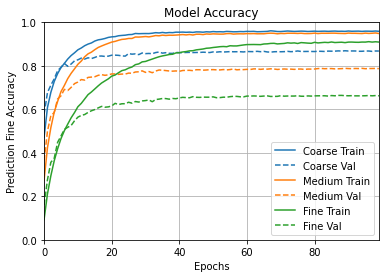

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

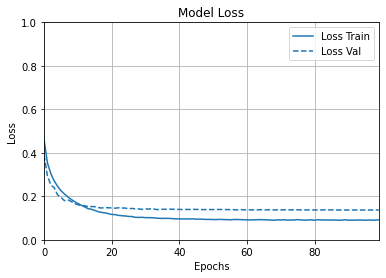

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 28ms/step - loss: 0.1613 - prediction_coarse_loss: 0.0989 - prediction_medium_loss: 0.1644 - prediction_fine_loss: 0.2754 - prediction_coarse_accuracy: 0.8681 - prediction_medium_accuracy: 0.7873 - prediction_fine_accuracy: 0.6623
1. loss ==> 0.16126248240470886
2. prediction_coarse_loss ==> 0.09892713278532028
3. prediction_medium_loss ==> 0.16444920003414154
4. prediction_fine_loss ==> 0.27535301446914673
5. prediction_coarse_accuracy ==> 0.8680999875068665
6. prediction_medium_accuracy ==> 0.7872999906539917
7. prediction_fine_accuracy ==> 0.6622999906539917
313/313 [==============================] - 8s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

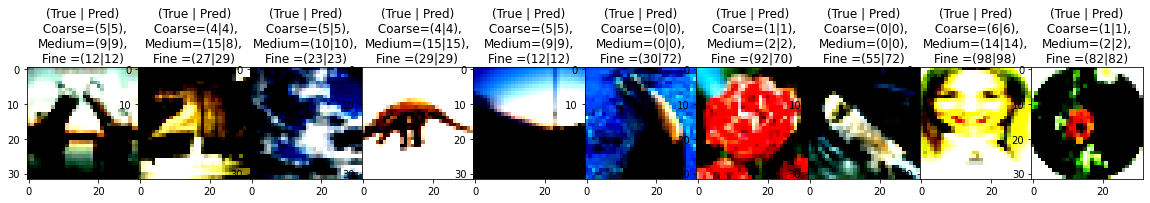

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 733   13   20   38  169    7    9   11]
 [   8 1365   29   31   40   21    0    6]
 [   6   26 1371   14   33   11   13   26]
 [  22   27   36  785  111    4    5   10]
 [  79   25   49  115 2203    7    6   16]
 [  14   23   21    8   17  899    0   18]
 [   8   10   10   12   35    0  423    2]
 [   9    3   29   11   19   27    0  902]]

  • MEDIUM LEVEL 
[[329  28   1   0   2   2   4   4  18   2   2  13  17  14   5  29  25   0
    2   3]
 [ 32 362   9   7   3   6   2   7   3   2   3   5   3  10   8  18  13   0
    2   5]
 [  0   4 454   2  12   3   1  11   2   2   2   0   0   2   0   0   1   1
    3   0]
 [  1   2   3 408  15  32   9   3   1   3   0   3   0   3   6   4   0   0
    1   6]
 [  2   1  20   9 425   8   0   3   4   1   1   1   2   8   1  11   3   0
    0   0]
 [  1   5   1  21   6 390  25   3   2   1   3   0   1   6  11   4   1   2
    7  10]
 [  1   0   0  15   2  26 426   2   2   3   2   1   0   1   5   4   1   1
    5   3]


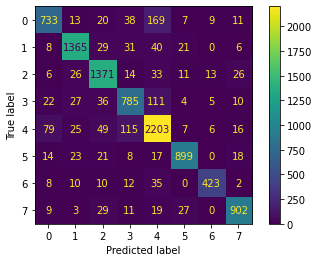

              precision    recall  f1-score   support

           0    0.83390   0.73300   0.78020      1000
           1    0.91488   0.91000   0.91243      1500
           2    0.87604   0.91400   0.89462      1500
           3    0.77416   0.78500   0.77954      1000
           4    0.83860   0.88120   0.85937      2500
           5    0.92111   0.89900   0.90992      1000
           6    0.92763   0.84600   0.88494       500
           7    0.91019   0.90200   0.90608      1000

    accuracy                        0.86810     10000
   macro avg    0.87456   0.85878   0.86589     10000
weighted avg    0.86861   0.86810   0.86772     10000


  • MEDIUM LEVEL 


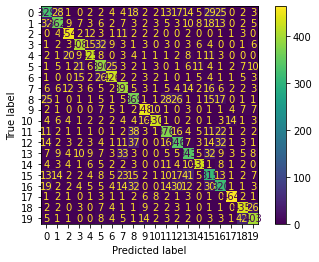

              precision    recall  f1-score   support

           0    0.68685   0.65800   0.67211       500
           1    0.79912   0.72400   0.75971       500
           2    0.86973   0.90800   0.88845       500
           3    0.83265   0.81600   0.82424       500
           4    0.84493   0.85000   0.84746       500
           5    0.73171   0.78000   0.75508       500
           6    0.84861   0.85200   0.85030       500
           7    0.74624   0.79400   0.76938       500
           8    0.67831   0.73800   0.70690       500
           9    0.86822   0.89600   0.88189       500
          10    0.91684   0.86000   0.88751       500
          11    0.75654   0.75200   0.75426       500
          12    0.72537   0.69200   0.70829       500
          13    0.70431   0.68600   0.69504       500
          14    0.88008   0.86600   0.87298       500
          15    0.61644   0.63000   0.62315       500
          16    0.66806   0.64000   0.65373       500
          17    0.93360   0

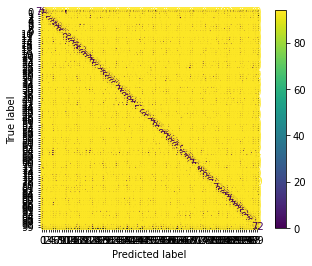

              precision    recall  f1-score   support

           0    0.85870   0.79000   0.82292       100
           1    0.79000   0.79000   0.79000       100
           2    0.51485   0.52000   0.51741       100
           3    0.48837   0.42000   0.45161       100
           4    0.58140   0.50000   0.53763       100
           5    0.70408   0.69000   0.69697       100
           6    0.73404   0.69000   0.71134       100
           7    0.63551   0.68000   0.65700       100
           8    0.84043   0.79000   0.81443       100
           9    0.74074   0.80000   0.76923       100
          10    0.53061   0.52000   0.52525       100
          11    0.39506   0.32000   0.35359       100
          12    0.68644   0.81000   0.74312       100
          13    0.67368   0.64000   0.65641       100
          14    0.57000   0.57000   0.57000       100
          15    0.62185   0.74000   0.67580       100
          16    0.66337   0.67000   0.66667       100
          17    0.82474   0

In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7709683333333335 
Hierarchical Recall = 0.7902 
Hierarchical F1-Score = 0.7785428571428572 
Consistency =  0.8862 
Exact Match =  0.6336


# Training Again

In [22]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1241 - prediction_coarse_accuracy: 0.9252 - prediction_medium_accuracy: 0.8972 - prediction_fine_accuracy: 0.8106
  • Coarse Accuracy = 92.52% | Val_Accuracy = 83.90% | LossWeight = 0.35 
  • Medium Accuracy = 89.72% | Val_Accuracy = 74.46% | LossWeight = 0.44 
  • Fine   Accuracy = 81.06% | Val_Accuracy = 60.86% | LossWeight = 0.21 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.66410
781/781 [==============================] - 104s 133ms/step - loss: 0.1241 - prediction_coarse_accuracy: 0.9252 - prediction_medium_accuracy: 0.8972 - prediction_fine_accuracy: 0.8106 - val_loss: 0.1642 - val_prediction_coarse_accuracy: 0.8390 - val_prediction_medium_accuracy: 0.7446 - val_prediction_fine_accuracy: 0.6086 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1166 - prediction_coarse_accuracy: 0.9298 - prediction_medium_accuracy: 0.9058 - prediction_fine_accuracy: 0.8141


Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1093 - prediction_coarse_accuracy: 0.9399 - prediction_medium_accuracy: 0.9197 - prediction_fine_accuracy: 0.8393
  • Coarse Accuracy = 93.99% | Val_Accuracy = 84.57% | LossWeight = 0.35 
  • Medium Accuracy = 91.97% | Val_Accuracy = 75.65% | LossWeight = 0.43 
  • Fine   Accuracy = 83.93% | Val_Accuracy = 62.66% | LossWeight = 0.22 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.66410
781/781 [==============================] - 104s 134ms/step - loss: 0.1093 - prediction_coarse_accuracy: 0.9399 - prediction_medium_accuracy: 0.9197 - prediction_fine_accuracy: 0.8393 - val_loss: 0.1546 - val_prediction_coarse_accuracy: 0.8457 - val_prediction_medium_accuracy: 0.7565 - val_prediction_fine_accuracy: 0.6266 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1058 - prediction_coarse_accuracy: 0.9445 - prediction_medium_accuracy: 0.9252 - prediction_fine_accuracy: 0.85

781/781 [==============================] - 104s 134ms/step - loss: 0.0969 - prediction_coarse_accuracy: 0.9526 - prediction_medium_accuracy: 0.9395 - prediction_fine_accuracy: 0.8885 - val_loss: 0.1491 - val_prediction_coarse_accuracy: 0.8570 - val_prediction_medium_accuracy: 0.7654 - val_prediction_fine_accuracy: 0.6375 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0966 - prediction_coarse_accuracy: 0.9524 - prediction_medium_accuracy: 0.9409 - prediction_fine_accuracy: 0.8944
  • Coarse Accuracy = 95.24% | Val_Accuracy = 85.67% | LossWeight = 0.38 
  • Medium Accuracy = 94.09% | Val_Accuracy = 77.43% | LossWeight = 0.42 
  • Fine   Accuracy = 89.44% | Val_Accuracy = 63.95% | LossWeight = 0.20 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.66410
781/781 [==============================] - 104s 134ms/step - loss: 0.0966 - prediction_coarse_accuracy: 0.9524 - prediction_medium_accuracy: 0.9409 - prediction_fine_accuracy: 0.894

781/781 [==============================] - ETA: 0s - loss: 0.0922 - prediction_coarse_accuracy: 0.9578 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.9164
  • Coarse Accuracy = 95.78% | Val_Accuracy = 86.98% | LossWeight = 0.39 
  • Medium Accuracy = 94.77% | Val_Accuracy = 78.31% | LossWeight = 0.43 
  • Fine   Accuracy = 91.64% | Val_Accuracy = 65.64% | LossWeight = 0.18 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.66410
781/781 [==============================] - 104s 133ms/step - loss: 0.0922 - prediction_coarse_accuracy: 0.9578 - prediction_medium_accuracy: 0.9477 - prediction_fine_accuracy: 0.9164 - val_loss: 0.1406 - val_prediction_coarse_accuracy: 0.8698 - val_prediction_medium_accuracy: 0.7831 - val_prediction_fine_accuracy: 0.6564 - lr: 3.7735e-04
Epoch 30/100
781/781 [==============================] - ETA: 0s - loss: 0.0920 - prediction_coarse_accuracy: 0.9580 - prediction_medium_accuracy: 0.9482 - prediction_fine_accuracy: 0.9162
  • Co

781/781 [==============================] - 104s 133ms/step - loss: 0.0903 - prediction_coarse_accuracy: 0.9591 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.9238 - val_loss: 0.1383 - val_prediction_coarse_accuracy: 0.8688 - val_prediction_medium_accuracy: 0.7888 - val_prediction_fine_accuracy: 0.6605 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0898 - prediction_coarse_accuracy: 0.9612 - prediction_medium_accuracy: 0.9519 - prediction_fine_accuracy: 0.9259
  • Coarse Accuracy = 96.12% | Val_Accuracy = 86.90% | LossWeight = 0.39 
  • Medium Accuracy = 95.19% | Val_Accuracy = 78.72% | LossWeight = 0.44 
  • Fine   Accuracy = 92.59% | Val_Accuracy = 65.92% | LossWeight = 0.17 

Epoch 39: val_prediction_fine_accuracy did not improve from 0.66410
781/781 [==============================] - 104s 133ms/step - loss: 0.0898 - prediction_coarse_accuracy: 0.9612 - prediction_medium_accuracy: 0.9519 - prediction_fine_accuracy: 0.925

781/781 [==============================] - ETA: 0s - loss: 0.0875 - prediction_coarse_accuracy: 0.9613 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.9313
  • Coarse Accuracy = 96.13% | Val_Accuracy = 87.11% | LossWeight = 0.40 
  • Medium Accuracy = 95.21% | Val_Accuracy = 78.98% | LossWeight = 0.44 
  • Fine   Accuracy = 93.13% | Val_Accuracy = 66.49% | LossWeight = 0.16 

Epoch 48: val_prediction_fine_accuracy improved from 0.66410 to 0.66490, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_2\epoch-best.h5
781/781 [==============================] - 104s 134ms/step - loss: 0.0875 - prediction_coarse_accuracy: 0.9613 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.9313 - val_loss: 0.1359 - val_prediction_coarse_accuracy: 0.8711 - val_prediction_medium_accuracy: 0.7898 - val_prediction_fine_accuracy: 0.6649 - lr: 1.4240e-04
Epoch 49/100
781/781 [==============================] - ETA: 0s - loss: 0.0878 - prediction_coarse_accuracy: 0.9610 -

781/781 [==============================] - ETA: 0s - loss: 0.0882 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.9321
  • Coarse Accuracy = 96.18% | Val_Accuracy = 87.11% | LossWeight = 0.40 
  • Medium Accuracy = 95.29% | Val_Accuracy = 79.21% | LossWeight = 0.44 
  • Fine   Accuracy = 93.21% | Val_Accuracy = 66.58% | LossWeight = 0.16 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.66780
781/781 [==============================] - 104s 134ms/step - loss: 0.0882 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.9321 - val_loss: 0.1345 - val_prediction_coarse_accuracy: 0.8711 - val_prediction_medium_accuracy: 0.7921 - val_prediction_fine_accuracy: 0.6658 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0865 - prediction_coarse_accuracy: 0.9626 - prediction_medium_accuracy: 0.9544 - prediction_fine_accuracy: 0.9342
  • Co

781/781 [==============================] - 104s 134ms/step - loss: 0.0862 - prediction_coarse_accuracy: 0.9632 - prediction_medium_accuracy: 0.9536 - prediction_fine_accuracy: 0.9352 - val_loss: 0.1333 - val_prediction_coarse_accuracy: 0.8729 - val_prediction_medium_accuracy: 0.7944 - val_prediction_fine_accuracy: 0.6662 - lr: 5.6562e-05
Epoch 67/100
781/781 [==============================] - ETA: 0s - loss: 0.0864 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9537 - prediction_fine_accuracy: 0.9342
  • Coarse Accuracy = 96.27% | Val_Accuracy = 87.35% | LossWeight = 0.40 
  • Medium Accuracy = 95.37% | Val_Accuracy = 79.59% | LossWeight = 0.44 
  • Fine   Accuracy = 93.42% | Val_Accuracy = 66.70% | LossWeight = 0.16 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.66980
781/781 [==============================] - 104s 133ms/step - loss: 0.0864 - prediction_coarse_accuracy: 0.9627 - prediction_medium_accuracy: 0.9537 - prediction_fine_accuracy: 0.934

781/781 [==============================] - ETA: 0s - loss: 0.0865 - prediction_coarse_accuracy: 0.9619 - prediction_medium_accuracy: 0.9534 - prediction_fine_accuracy: 0.9347
  • Coarse Accuracy = 96.19% | Val_Accuracy = 87.47% | LossWeight = 0.40 
  • Medium Accuracy = 95.34% | Val_Accuracy = 79.73% | LossWeight = 0.44 
  • Fine   Accuracy = 93.47% | Val_Accuracy = 66.90% | LossWeight = 0.16 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.66980
781/781 [==============================] - 104s 133ms/step - loss: 0.0865 - prediction_coarse_accuracy: 0.9619 - prediction_medium_accuracy: 0.9534 - prediction_fine_accuracy: 0.9347 - val_loss: 0.1327 - val_prediction_coarse_accuracy: 0.8747 - val_prediction_medium_accuracy: 0.7973 - val_prediction_fine_accuracy: 0.6690 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0866 - prediction_coarse_accuracy: 0.9628 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.9365
  • Co

781/781 [==============================] - 104s 133ms/step - loss: 0.0852 - prediction_coarse_accuracy: 0.9637 - prediction_medium_accuracy: 0.9564 - prediction_fine_accuracy: 0.9393 - val_loss: 0.1323 - val_prediction_coarse_accuracy: 0.8760 - val_prediction_medium_accuracy: 0.7965 - val_prediction_fine_accuracy: 0.6692 - lr: 2.1344e-05
Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0864 - prediction_coarse_accuracy: 0.9646 - prediction_medium_accuracy: 0.9558 - prediction_fine_accuracy: 0.9381
  • Coarse Accuracy = 96.46% | Val_Accuracy = 87.48% | LossWeight = 0.39 
  • Medium Accuracy = 95.58% | Val_Accuracy = 79.58% | LossWeight = 0.44 
  • Fine   Accuracy = 93.81% | Val_Accuracy = 66.94% | LossWeight = 0.16 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.67030
781/781 [==============================] - 104s 133ms/step - loss: 0.0864 - prediction_coarse_accuracy: 0.9646 - prediction_medium_accuracy: 0.9558 - prediction_fine_accuracy: 0.938

781/781 [==============================] - ETA: 0s - loss: 0.0856 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9555 - prediction_fine_accuracy: 0.9386
  • Coarse Accuracy = 96.35% | Val_Accuracy = 87.63% | LossWeight = 0.40 
  • Medium Accuracy = 95.55% | Val_Accuracy = 79.67% | LossWeight = 0.44 
  • Fine   Accuracy = 93.86% | Val_Accuracy = 67.03% | LossWeight = 0.16 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.67060
781/781 [==============================] - 104s 133ms/step - loss: 0.0856 - prediction_coarse_accuracy: 0.9635 - prediction_medium_accuracy: 0.9555 - prediction_fine_accuracy: 0.9386 - val_loss: 0.1324 - val_prediction_coarse_accuracy: 0.8763 - val_prediction_medium_accuracy: 0.7967 - val_prediction_fine_accuracy: 0.6703 - lr: 1.2779e-05
Epoch 96/100
781/781 [==============================] - ETA: 0s - loss: 0.0851 - prediction_coarse_accuracy: 0.9646 - prediction_medium_accuracy: 0.9567 - prediction_fine_accuracy: 0.9389
  • Co

In [23]:
history_dict = history.history

(0.0, 1.0)

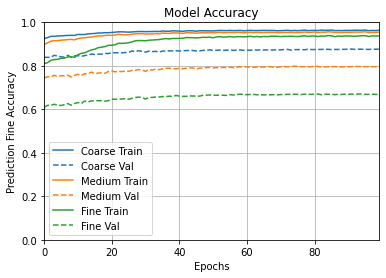

In [24]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

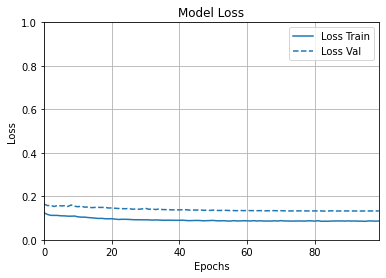

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [26]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 27ms/step - loss: 0.1492 - prediction_coarse_loss: 0.0928 - prediction_medium_loss: 0.1558 - prediction_fine_loss: 0.2722 - prediction_coarse_accuracy: 0.8768 - prediction_medium_accuracy: 0.7974 - prediction_fine_accuracy: 0.6683
1. loss ==> 0.14920613169670105
2. prediction_coarse_loss ==> 0.09275864064693451
3. prediction_medium_loss ==> 0.15575863420963287
4. prediction_fine_loss ==> 0.2721708416938782
5. prediction_coarse_accuracy ==> 0.876800000667572
6. prediction_medium_accuracy ==> 0.7973999977111816
7. prediction_fine_accuracy ==> 0.6682999730110168
313/313 [==============================] - 7s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

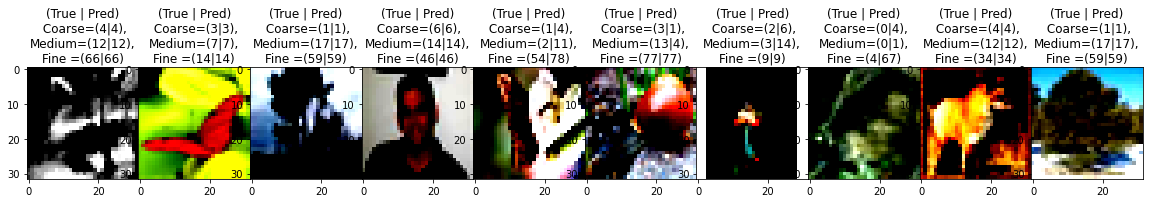

In [27]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 747   12   19   31  154    7   16   14]
 [   6 1379   33   29   29   18    0    6]
 [   8   20 1385   20   24   10    9   24]
 [  21   31   37  805   89    2    4   11]
 [  83   16   54   93 2221    8    8   17]
 [  10   20   20    6   21  900    1   22]
 [   8   10    7   15   34    0  421    5]
 [   8    1   27   10   18   26    0  910]]

  • MEDIUM LEVEL 
[[333  34   0   1   2   3   1   6  17   1   2  15  14  14   8  20  24   0
    1   4]
 [ 29 374   6   2   4   7   2   7   4   2   4   4   2   9  11  16  12   1
    1   3]
 [  0   3 452   3  15   1   1  12   2   1   1   1   0   5   0   0   0   1
    1   1]
 [  1   1   4 419   9  31   5   1   0   3   0   3   0   6   8   1   0   0
    2   6]
 [  2   1  17   9 434  13   0   3   6   1   0   0   2   5   0   4   3   0
    0   0]
 [  0   3   1  22   4 404  21   6   1   2   2   2   1   6   8   3   3   2
    3   6]
 [  1   2   2  15   1  20 436   3   1   3   1   1   0   1   1   2   0   1
    3   6]


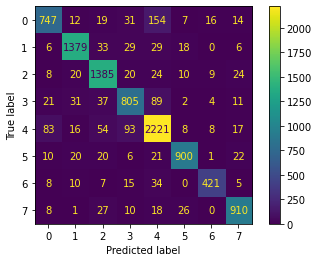

              precision    recall  f1-score   support

           0    0.83838   0.74700   0.79006      1000
           1    0.92612   0.91933   0.92272      1500
           2    0.87547   0.92333   0.89877      1500
           3    0.79782   0.80500   0.80139      1000
           4    0.85753   0.88840   0.87269      2500
           5    0.92688   0.90000   0.91324      1000
           6    0.91721   0.84200   0.87800       500
           7    0.90188   0.91000   0.90592      1000

    accuracy                        0.87680     10000
   macro avg    0.88016   0.86688   0.87285     10000
weighted avg    0.87698   0.87680   0.87636     10000


  • MEDIUM LEVEL 


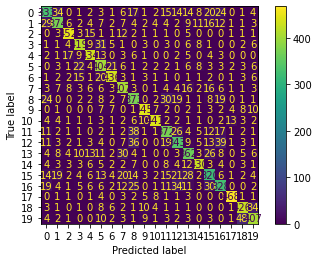

              precision    recall  f1-score   support

           0    0.71306   0.66600   0.68873       500
           1    0.79070   0.74800   0.76876       500
           2    0.89328   0.90400   0.89861       500
           3    0.83466   0.83800   0.83633       500
           4    0.84600   0.86800   0.85686       500
           5    0.71378   0.80800   0.75797       500
           6    0.87550   0.87200   0.87375       500
           7    0.76075   0.81400   0.78647       500
           8    0.68819   0.74600   0.71593       500
           9    0.89537   0.89000   0.89268       500
          10    0.92259   0.88200   0.90184       500
          11    0.75304   0.74400   0.74849       500
          12    0.71608   0.68600   0.70072       500
          13    0.72545   0.72400   0.72472       500
          14    0.87935   0.86000   0.86957       500
          15    0.66667   0.64000   0.65306       500
          16    0.69345   0.65600   0.67420       500
          17    0.94355   0

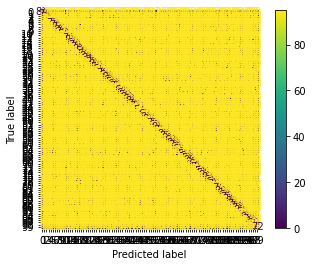

              precision    recall  f1-score   support

           0    0.85263   0.81000   0.83077       100
           1    0.75238   0.79000   0.77073       100
           2    0.59794   0.58000   0.58883       100
           3    0.46512   0.40000   0.43011       100
           4    0.50000   0.47000   0.48454       100
           5    0.68571   0.72000   0.70244       100
           6    0.77174   0.71000   0.73958       100
           7    0.62393   0.73000   0.67281       100
           8    0.89583   0.86000   0.87755       100
           9    0.80412   0.78000   0.79188       100
          10    0.53465   0.54000   0.53731       100
          11    0.44000   0.33000   0.37714       100
          12    0.71698   0.76000   0.73786       100
          13    0.65432   0.53000   0.58564       100
          14    0.61062   0.69000   0.64789       100
          15    0.59829   0.70000   0.64516       100
          16    0.70476   0.74000   0.72195       100
          17    0.82653   0

In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7783816666666666 
Hierarchical Recall = 0.7955999999999999 
Hierarchical F1-Score = 0.7851519841269841 
Consistency =  0.8978 
Exact Match =  0.6441
